In [21]:
import json
import os
import torch
from itertools import product
from scipy.stats import beta
from scipy.integrate import quad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# @title Select numerical precision
numerical_precision = torch.float64 # @param ["torch.float32","torch.float64"] {"type":"raw"}
num_experiments = 220 # @param {"type":"slider","min":1,"max":1000,"step":1}

In [23]:
results_file_name = f"numerical_stability_results_{numerical_precision.__reduce__()}_n{num_experiments}.json"

if os.path.exists(results_file_name):
    with open(results_file_name, 'r') as fp:
        results = json.load(fp)
else:
    from numerical_stability import get_results

    with open("pmDAGs.json", 'r') as fp:
        data = json.load(fp)

    results = get_results(data, num_experiments, numerical_precision)

    with open(results_file_name, 'w') as fp:
        json.dump(results, fp)

In [24]:
def prob_a_better(p_a, p_b, n):
    def prob_p1_gt_p2(alpha1, beta1, alpha2, beta2):
        integrand = lambda p: beta.pdf(p, alpha1, beta1) * beta.cdf(p, alpha2, beta2)
        result, _ = quad(integrand, 0, 1)
        return result

    # Observed data
    n_a, n_b = p_a * n, p_b * n

    # Prior: Beta(1, 1) = Uniform (uninformative)
    alpha, beta_param = 1, 1

    return prob_p1_gt_p2(n_a + alpha, n - n_a + beta_param, n_b + alpha, n - n_b + beta_param)

In [25]:

df = pd.DataFrame(columns=['name', 'method', 'loss', 'lr', 'success_rate'])

for name, experiments in results.items():
    for lr, losses in experiments.items():
        for loss, methods in losses.items():
            for method, success_count in methods.items():
                df.loc[len(df), df.columns] = name, method, loss, lr, success_count / num_experiments

methods = df["method"].unique()
losses = df["loss"].unique()
df = df.pivot(index=("name", "lr"), columns=("loss", "method"), values="success_rate").reset_index()

for loss in losses:
    df[f"{loss} P({methods[0]}>{methods[1]})"] = df.apply(lambda row: prob_a_better(*row[loss], num_experiments), axis=1)

df.columns = ['+'.join(filter(None, col)) for col in df.columns]
df.round(3)

,name,lr,KullbackLeibler+ACCUM,KullbackLeibler+COVAR,Bhattacharyya+ACCUM,Bhattacharyya+COVAR,SquaredHellinger+ACCUM,SquaredHellinger+COVAR,KullbackLeibler P(ACCUM>COVAR),Bhattacharyya P(ACCUM>COVAR),SquaredHellinger P(ACCUM>COVAR)
0,IV,0.0001,0.995455,0.995455,1.0,1.0,1.0,1.0,0.500,0.5,0.500
1,IV,0.001,0.968182,0.972727,1.0,1.0,1.0,1.0,0.394,0.5,0.500
2,IV,0.01,0.904545,0.918182,1.0,1.0,1.0,1.0,0.310,0.5,0.500
3,IV,0.1,0.563636,0.572727,1.0,1.0,1.0,1.0,0.424,0.5,0.500
4,IV,1,0.018182,0.009091,1.0,1.0,1.0,1.0,0.775,0.5,0.500
5,IV,10,0.0,0.0,1.0,1.0,1.0,1.0,0.500,0.5,0.500
6,M,0.0001,1.0,1.0,1.0,1.0,1.0,1.0,0.500,0.5,0.500
7,M,0.001,0.995455,0.995455,1.0,1.0,1.0,1.0,0.500,0.5,0.500
8,M,0.01,0.990909,0.990909,1.0,1.0,1.0,1.0,0.500,0.5,0.500
9,M,0.1,0.9,0.886364,1.0,1.0,1.0,1.0,0.677,0.5,0.500


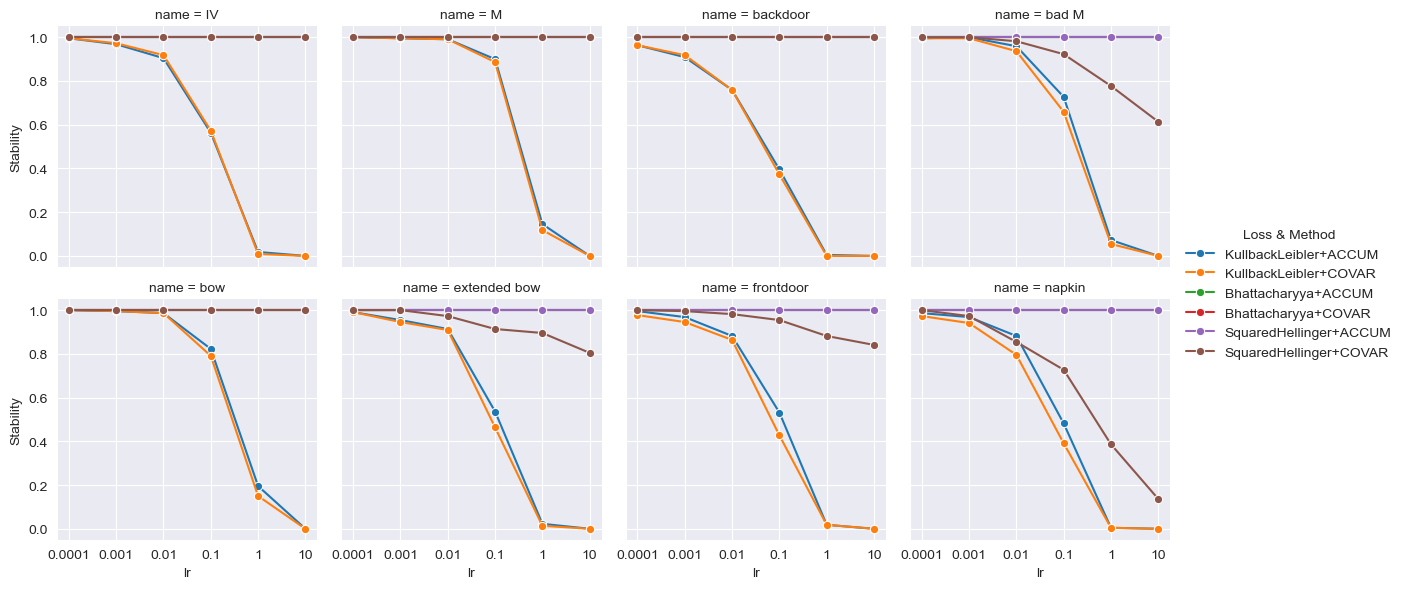

In [26]:
grid = sns.FacetGrid(df, col="name", palette="tab20c", col_wrap=4, height=3)
palette = sns.color_palette("tab10")

for i, combination in enumerate(product(losses, methods)):
    grid.map(sns.lineplot, "lr", column := '+'.join(combination), label=column, color=palette[i], marker='o')

grid.set_ylabels("Stability")
grid.add_legend(title="Loss & Method")
plt.show()

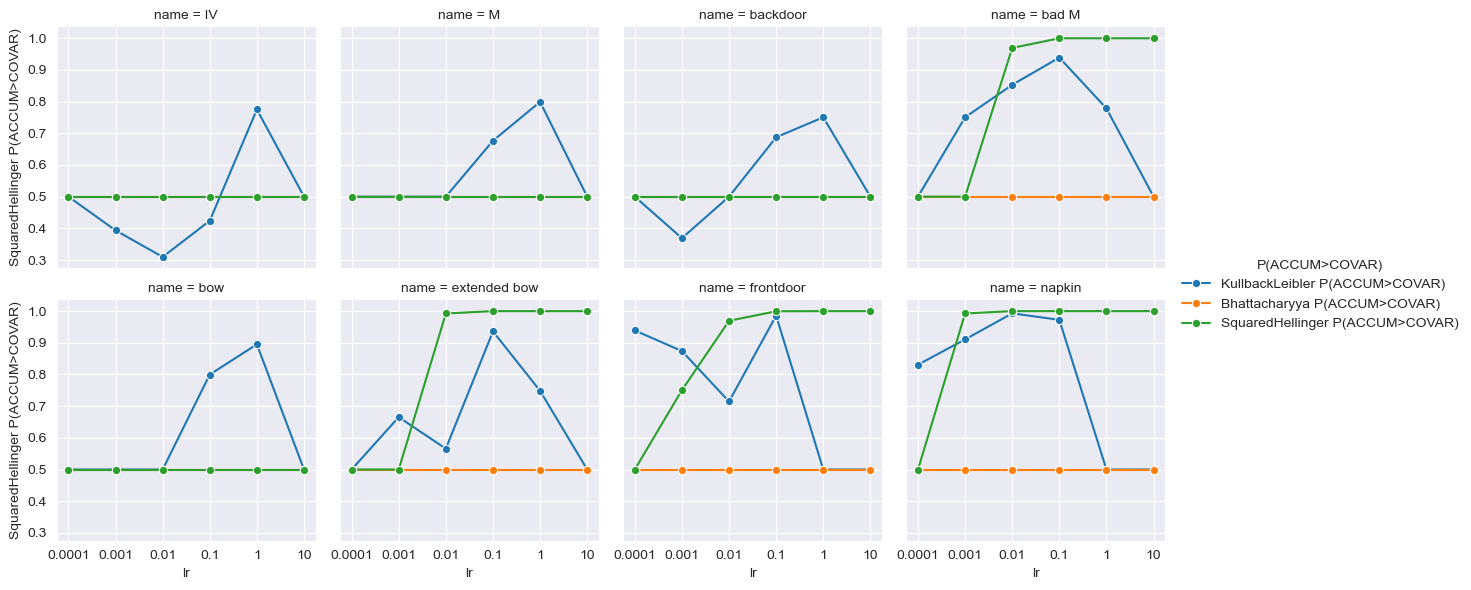

In [27]:
grid = sns.FacetGrid(df, col="name", palette="tab20c", col_wrap=4, height=3)
palette = sns.color_palette("tab10")

for i, loss in enumerate(losses):
    grid.map(sns.lineplot, "lr", column := f"{loss} P({methods[0]}>{methods[1]})", label=column, color=palette[i], marker='o')

grid.add_legend(title=f"P({methods[0]}>{methods[1]})")
plt.show()